# Binary approach

In [9]:
# Libraries
using DataFrames;
using CSV;
using Random;
using Statistics;
using ScikitLearn;
using Flux.Losses;
using Flux;
using Plots;
using StatsPlots;
using Printf;

@sk_import impute: KNNImputer; # Imputation of missing values.
@sk_import svm: SVC;
@sk_import decomposition: PCA;
@sk_import tree: DecisionTreeClassifier;
@sk_import neighbors: KNeighborsClassifier;
@sk_import feature_selection: SelectKBest; # Feature Selection
@sk_import feature_selection: f_classif; # Used with SelectKBest

include("utils/fluxANNs.jl"); # for ANN training with Flux
include("utils/evaluation.jl"); # for confusion matrix calculatestimatorsion and cross validation set partitioning
include("utils/preprocessing.jl"); # for normalization, one-hot encoding, holdout division
include("utils/training.jl"); # for crossvalidation methodology
include("utils/visualizations.jl"); # for plots

# Set seed
Random.seed!(10);

# Hold-out partition

In [10]:
# loading the dataset
support2 = CSV.read("datasets/support2_cleaned.csv", DataFrame, delim = ',');

# fate: 0 = recovery, 1 = death at home, 2 = death at the hospital
support2[:, "fate"] = support2[:,"death"] + support2[:,"hospdead"];
target_cols = ["death", "hospdead", "fate"];

trainIndex, testIndex = holdOut(nrow(support2), 0.2);

trainInputs = Array(support2[trainIndex, Not(target_cols)]);
testInputs = Array(support2[testIndex, Not(target_cols)]);

trainTargets = Array(support2[trainIndex, "death"]);
testTargets = Array(support2[testIndex, "death"]);

# Kfold
kFoldIndices = crossvalidation(trainTargets, 5);

# Imputation

In [11]:
imputer = KNNImputer(n_neighbors = 5);

trainInputs[:,1:32] = fit_transform!(imputer, trainInputs[:,1:32]);
testInputs[:,1:32] = imputer.transform(testInputs[:,1:32]);

# Visualizations

In [15]:
meanTrain, stdTrain = calculateZeroMeanNormalizationParameters(trainInputs[:,1:32]);
numInputs = normalizeZeroMean!(trainInputs[:,1:32], (meanTrain, stdTrain));

plot_correlations(numInputs);
savefig("plots/correlations.png");

# Train PCA on training dataset.
pca = PCA(2);
pcaInputs = fit_transform!(pca, numInputs);

# Draw results
draw_results(pcaInputs, trainTargets; colors=[:green,:red], target_names=["Survived", "Died"]);
savefig("plots/pca.png");

- ANN

In [12]:
ANNparams = [Dict("topology" => [2], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [4], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [8], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [16], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [2, 2], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [4, 4], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [8, 8], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [16, 16], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1)]

models = [(:ANN, ANNparams)];

(modelType, params) = findBestModel(models, trainInputs, trainTargets, kFoldIndices);
println("Best model is ", modelType, " with hyperparameters:");
println(params);


Training ANN models:
Configuration 1: Dict{String, Any}("maxEpochs" => 500, "learningRate" => 0.01, "topology" => [2], "validationRatio" => 0.1, "maxEpochsVal" => 20, "minLoss" => 0.0)
Accuracy:0.8743163816396494 (87.43%), stdDev:0.009063449873167932 (0.91%)
F1-Score:0.9065116697044904 (90.65%), stdDev:0.006060756018843348 (0.61%)

Configuration 2: Dict{String, Any}("maxEpochs" => 500, "learningRate" => 0.01, "topology" => [4], "validationRatio" => 0.1, "maxEpochsVal" => 20, "minLoss" => 0.0)
Accuracy:0.8750768139893447 (87.51%), stdDev:0.006609962853716415 (0.66%)
F1-Score:0.9071626400046237 (90.72%), stdDev:0.004258905594732289 (0.43%)

Configuration 3: Dict{String, Any}("maxEpochs" => 500, "learningRate" => 0.01, "topology" => [8], "validationRatio" => 0.1, "maxEpochsVal" => 20, "minLoss" => 0.0)
Accuracy:0.8738041468772575 (87.38%), stdDev:0.006532136478739883 (0.65%)
F1-Score:0.9066228020895633 (90.66%), stdDev:0.004271603450772876 (0.43%)

Configuration 4: Dict{String, Any}("max

- SVM

In [5]:
SVMparams = [Dict("kernel" => "linear", "degree" => 0, "gamma" => "scale", "C" => 0.1),
            Dict("kernel" => "linear", "degree" => 0, "gamma" => "scale", "C" => 1),
            Dict("kernel" => "rbf", "degree" => 0, "gamma" => "scale", "C" => 0.1),
            Dict("kernel" => "rbf", "degree" => 0, "gamma" => "scale", "C" => 1),
            Dict("kernel" => "sigmoid", "degree" => 0, "gamma" => "scale", "C" => 0.1),
            Dict("kernel" => "sigmoid", "degree" => 0, "gamma" => "scale", "C" => 1),
            Dict("kernel" => "poly", "degree" => 3, "gamma" => "scale", "C" => 0.1),
            Dict("kernel" => "poly", "degree" => 3, "gamma" => "scale", "C" => 1)]

models = [(:SVM, SVMparams)];

(modelType, params) = findBestModel(models, trainInputs, trainTargets, kFoldIndices);
println("Best model is ", modelType, " with hyperparameters:");
println(params);


Training SVM models:
Configuration 1: Dict{String, Any}("C" => 0.1, "kernel" => "linear", "gamma" => "scale", "degree" => 0)
Accuracy:0.8710225795572463 (87.10%), stdDev:0.008168228945039118 (0.82%)
F1-Score:0.8625125980665945 (86.25%), stdDev:0.05878984309458853 (5.88%)

Configuration 2: Dict{String, Any}("C" => 1, "kernel" => "linear", "gamma" => "scale", "degree" => 0)
Accuracy:0.8707452839602647 (87.07%), stdDev:0.008560852839665472 (0.86%)
F1-Score:0.8617262345563412 (86.17%), stdDev:0.06000276936670979 (6.00%)

Configuration 3: Dict{String, Any}("C" => 0.1, "kernel" => "rbf", "gamma" => "scale", "degree" => 0)
Accuracy:0.8484637434134678 (84.85%), stdDev:0.004994287742215206 (0.50%)
F1-Score:0.8321750420559477 (83.22%), stdDev:0.08453087621936052 (8.45%)

Configuration 4: Dict{String, Any}("C" => 1, "kernel" => "rbf", "gamma" => "scale", "degree" => 0)
Accuracy:0.8735139298336559 (87.35%), stdDev:0.005182180075704869 (0.52%)
F1-Score:0.8655430789895429 (86.55%), stdDev:0.0553836

- DecisionTree

In [6]:
DTreeParams = [Dict("maxDepth" => 4), Dict("maxDepth" => 8), Dict("maxDepth" => 16),
                Dict("maxDepth" => 32), Dict("maxDepth" => 64), Dict("maxDepth" => 128)]

models = [(:DTree, DTreeParams)];

(modelType, params) = findBestModel(models, trainInputs, trainTargets, kFoldIndices);
println("Best model is ", modelType, " with hyperparameters:");
println(params);


Training DTree models:
Configuration 1: Dict("maxDepth" => 4)
Accuracy:0.8814044504413616 (88.14%), stdDev:0.010580018742966515 (1.06%)
F1-Score:0.8799926950119861 (88.00%), stdDev:0.030864728736646824 (3.09%)

Configuration 2: Dict("maxDepth" => 8)
Accuracy:0.8815413265941461 (88.15%), stdDev:0.008921266200336416 (0.89%)
F1-Score:0.8756169290826558 (87.56%), stdDev:0.046578348264181973 (4.66%)

Configuration 3: Dict("maxDepth" => 16)
Accuracy:0.8635470934875175 (86.35%), stdDev:0.012844999924195546 (1.28%)
F1-Score:0.8520723597142931 (85.21%), stdDev:0.0735627473561319 (7.36%)

Configuration 4: Dict("maxDepth" => 32)
Accuracy:0.8616107171447087 (86.16%), stdDev:0.012215532729550385 (1.22%)
F1-Score:0.8499314426205121 (84.99%), stdDev:0.07349619124323109 (7.35%)

Configuration 5: Dict("maxDepth" => 64)
Accuracy:0.8616107171447087 (86.16%), stdDev:0.012215532729550385 (1.22%)
F1-Score:0.8499314426205121 (84.99%), stdDev:0.07349619124323109 (7.35%)

Configuration 6: Dict("maxDepth" => 1

- KNN

In [7]:
KNNparams = [Dict("k" => 3), Dict("k" => 6), Dict("k" => 12),
            Dict("k" => 24), Dict("k" => 48), Dict("k" => 96)]

models = [(:KNN, KNNparams)];

(modelType, params) = findBestModel(models, trainInputs, trainTargets, kFoldIndices);
println("Best model is ", modelType, " with hyperparameters:");

println(params);


Training KNN models:
Configuration 1: Dict("k" => 3)
Accuracy:

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x74ed6e9c0e00>
Traceback (most recent call last):
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attr

0.8015527017964914 (80.16%), stdDev:0.007605018524509869 (0.76%)
F1-Score:0.7873793440913506 (78.74%), stdDev:0.09437289688874852 (9.44%)

Configuration 2: Dict("k" => 6)
Accuracy:0.8090235911459317

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x74ed6e9c0e00>
Traceback (most recent call last):
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attr

 (80.90%), stdDev:0.0065582347158610384 (0.66%)
F1-Score:0.7994572416455643 (79.95%), stdDev:0.08182631154596007 (8.18%)

Configuration 3: Dict("k" => 12)
Accuracy:

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x74ed6e9c0e00>
Traceback (most recent call last):
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attr

0.8188480944822558 (81.88%), stdDev:0.00401362591921825 (0.40%)
F1-Score:0.8054492472070128 (80.54%), stdDev:0.08683314788738472 (8.68%)

Configuration 4: Dict("k" => 24)
Accuracy:0.8192635105667095

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x74ed6e9c0e00>
Traceback (most recent call last):
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attr

 (81.93%), stdDev:0.004986209446940596 (0.50%)
F1-Score:0.8031447731095847 (80.31%), stdDev:0.09298026549007038 (9.30%)

Configuration 5: Dict("k" => 48)
Accuracy:

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x74ed6e9c0e00>
Traceback (most recent call last):
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attr

0.82341547334294 (82.34%), stdDev:0.002204239314738125 (0.22%)
F1-Score:0.8078797409722585 (80.79%), stdDev:0.0899609552063971 (9.00%)

Configuration 6: Dict("k" => 96)
Accuracy:0.8217547652576398

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x74ed6e9c0e00>
Traceback (most recent call last):
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attr

 (82.18%), stdDev:0.0025226145428801313 (0.25%)
F1-Score:0.8052449521486625 (80.52%), stdDev:0.09280904186144937 (9.28%)

Best model is KNN with hyperparameters:
Dict("k" => 48)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x74ed6e9c0e00>
Traceback (most recent call last):
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attr

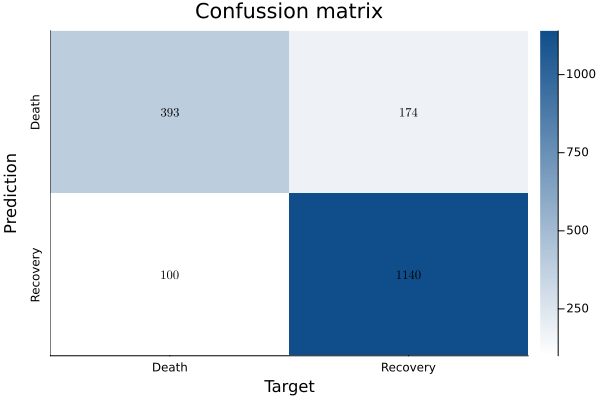

In [8]:
using Plots;

# train best model with all paterns and build confusion matrix with all patterns
train = (trainInputs, trainTargets); test = (testInputs, testTargets);

# normalization and validation set computation if needed
valRatio = if modelType != :ANN 0. else params["validationRatio"] end
train, val, test = prepareDataForFitting(train, test, valRatio)

classes = unique(trainTargets)
matAndMetrics = fitAndConfusion(modelType, params, train, val, test, classes)
confMat = matAndMetrics[8]

class_map = Dict(0 => "Recovery", 1 => "Death")
classNames = [class_map[class] for class in classes]
displayConfMat(confMat, classNames)

- Ensemble

In [15]:
@sk_import ensemble:StackingClassifier

# An ANN flux model cannot be included in a Scikit ensemble due to PyCall wrapping issues
estimators = [:KNN, :DTree, :SVM]
params = []
DTreeParams = Dict("maxDepth" => 4)
KNNparams = Dict("k" => 48)
SVMparams = Dict("C" => 1, "kernel" => "rbf", "gamma" => "scale", "degree" => 0)

params = Vector{Dict}([KNNparams, DTreeParams, SVMparams])

printCrossValOutput(trainClassEnsemble(estimators, params, (trainInputs, trainTargets),
                   crossvalidation(trainTargets, 5)));

Accuracy:0.8919172596446444

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x74ed6b9b79c0>
Traceback (most recent call last):
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attr

 (89.19%), stdDev:0.006268623175852334 (0.63%)
F1-Score:0.9033279319354186 (90.33%), stdDev:0.03050861152351613 (3.05%)



Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x74edd1f01c60>
Traceback (most recent call last):
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attr

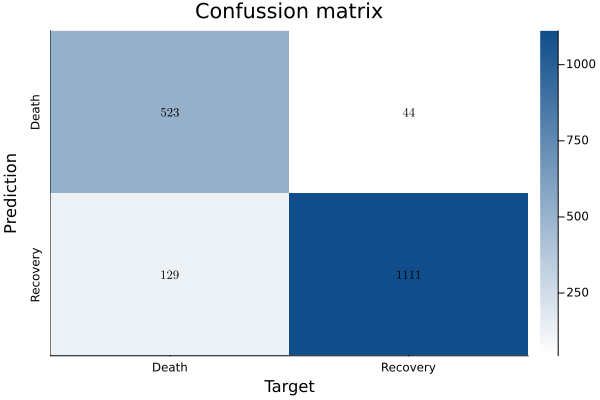

In [16]:
using Plots;

# train best model with all paterns and build confusion matrix with all patterns
train = (trainInputs, trainTargets); test = (testInputs, testTargets);

# standardization is applied
trainNorm, _, testNorm = prepareDataForFitting(train, test)
ensemble = fitEnsemble(trainNorm, estimators, params)

classes = unique(trainTargets)
matAndMetrics = confusionMatrix(predict(ensemble, testNorm[1]), testNorm[2]; weighted=true)
confMat = matAndMetrics[8]

class_map = Dict(0 => "Recovery", 1 => "Death")
classNames = [class_map[class] for class in classes]
displayConfMat(confMat, classNames)